# Group Project: Machine Learning 

- <a href='#part1'>Part 1: Deep L-Layer Neural Network for Image Classification</a>
	- You will use pre-built functions to build an L-Layer neural network for an image classification task
- <a href='#part2'>Part 2: Full Machine Learning Project</a>
	- You will go through the full "idea, code, experiment" cycle to build and improve a model of your choice

You may work in groups of 1-3 students for this project.

In this project, especially in Part 2, you are expected to show the work you have done in the form of including results for models you have experimented with on the path to the best-performing model. Make sure you include Python and markdown boxes explaining and discussing any decisions you have made and interpretations of the results you have achieved. You can include diagrams, tables, and/or graphs using markdown. **A significant portion of your grade will be based on the progression of your model, not just the final result.**

**Note**: All work you submit must be the work of your group. Projects will be checked against each other, and against any work submitted in previous semesters where a similar project was given.

<a id="part1"></a>
## Part 1: Deep L-Layer Neural Network for Image Classification

You will use the functions given to you to build a deep L-layer network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

### 1.1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](https://pillow.readthedocs.io/en/stable/index.html) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- nn_functions provides the functions you need to build an L-layer network.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from nn_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 1.2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in your previous assignment. The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset containing:
- a training set of m_train images labelled as cat (1) or non-cat (0)
- a test set of m_test images labelled as cat and non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a cat picture.


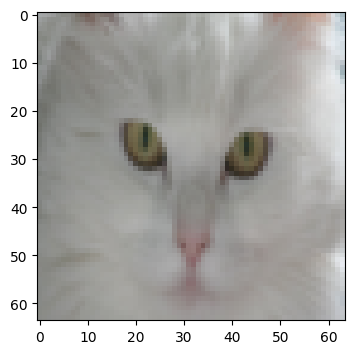

In [3]:
# Example of a picture
index = 50
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

### 1.3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

Here is a simplified network representation for an L-layer neural network:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: L-layer neural network.</center></caption> 

The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

<u>General methodology</u>

As usual you will follow the Deep Learning methodology to build the model:
1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    - Forward propagation
    - Compute cost function
    - Backward propagation
    - Update parameters (using parameters, and grads from backprop) 
4. Use trained parameters to predict labels

### 1.4 - L-layer Neural Network

**Exercise**: Use the helper functions in the nn_functions file to build an $L$-layer neural network with the following structure: **[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID**. Spend some time looking through the functions and understanding how they can be used to build a deep neural network. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [8]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)

    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL,caches = L_model_forward(X,parameters)
        # Compute cost.
        cost = compute_cost(AL,Y)
        # Backward propagation.
        grads = L_model_backward(AL,Y,caches)
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take a few minutes to run 2500 iterations. 

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


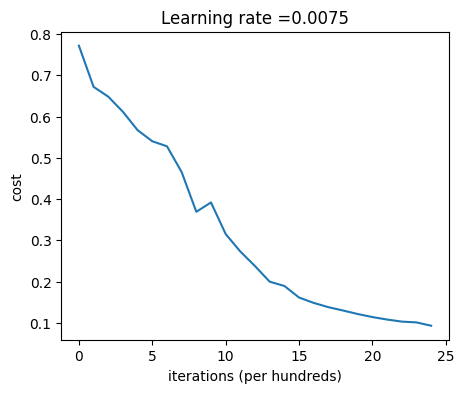

In [9]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [10]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [11]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


Congratulations! It seems that your 4-layer neural network has better performance than your previous assignment network on the same test set. 

This is good performance for this task.

###  1.5 - Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

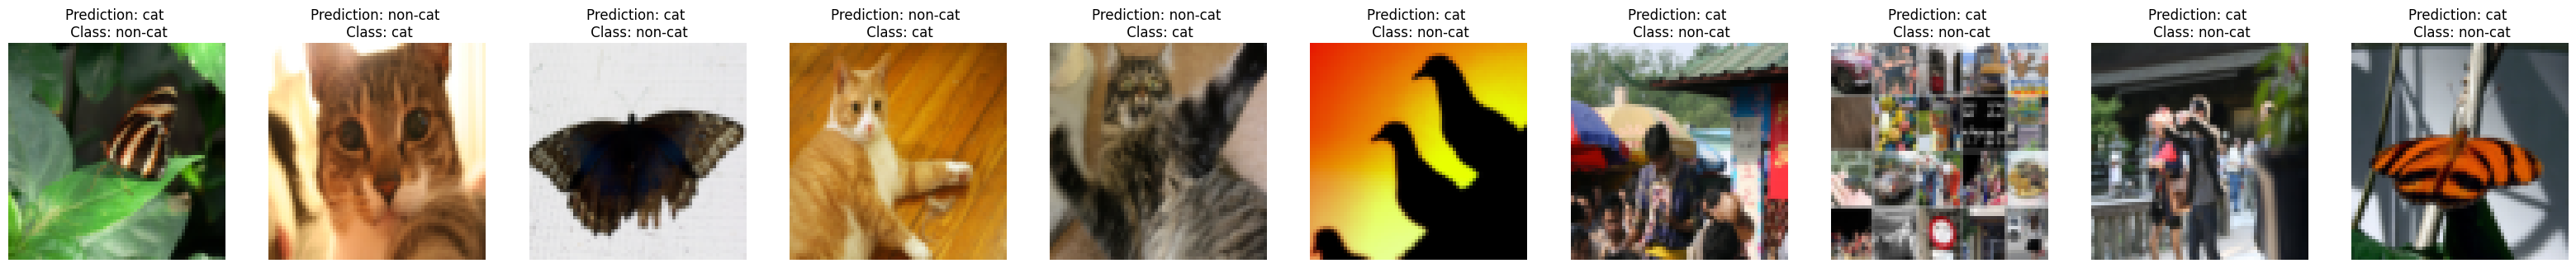

In [12]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### 1.6 - Test with your own image (optional/ungraded exercise) ##

You can use your own image and see the output of your model. To do that:
1. Add your image to the "images" folder
2. Change your image's name in the following code
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


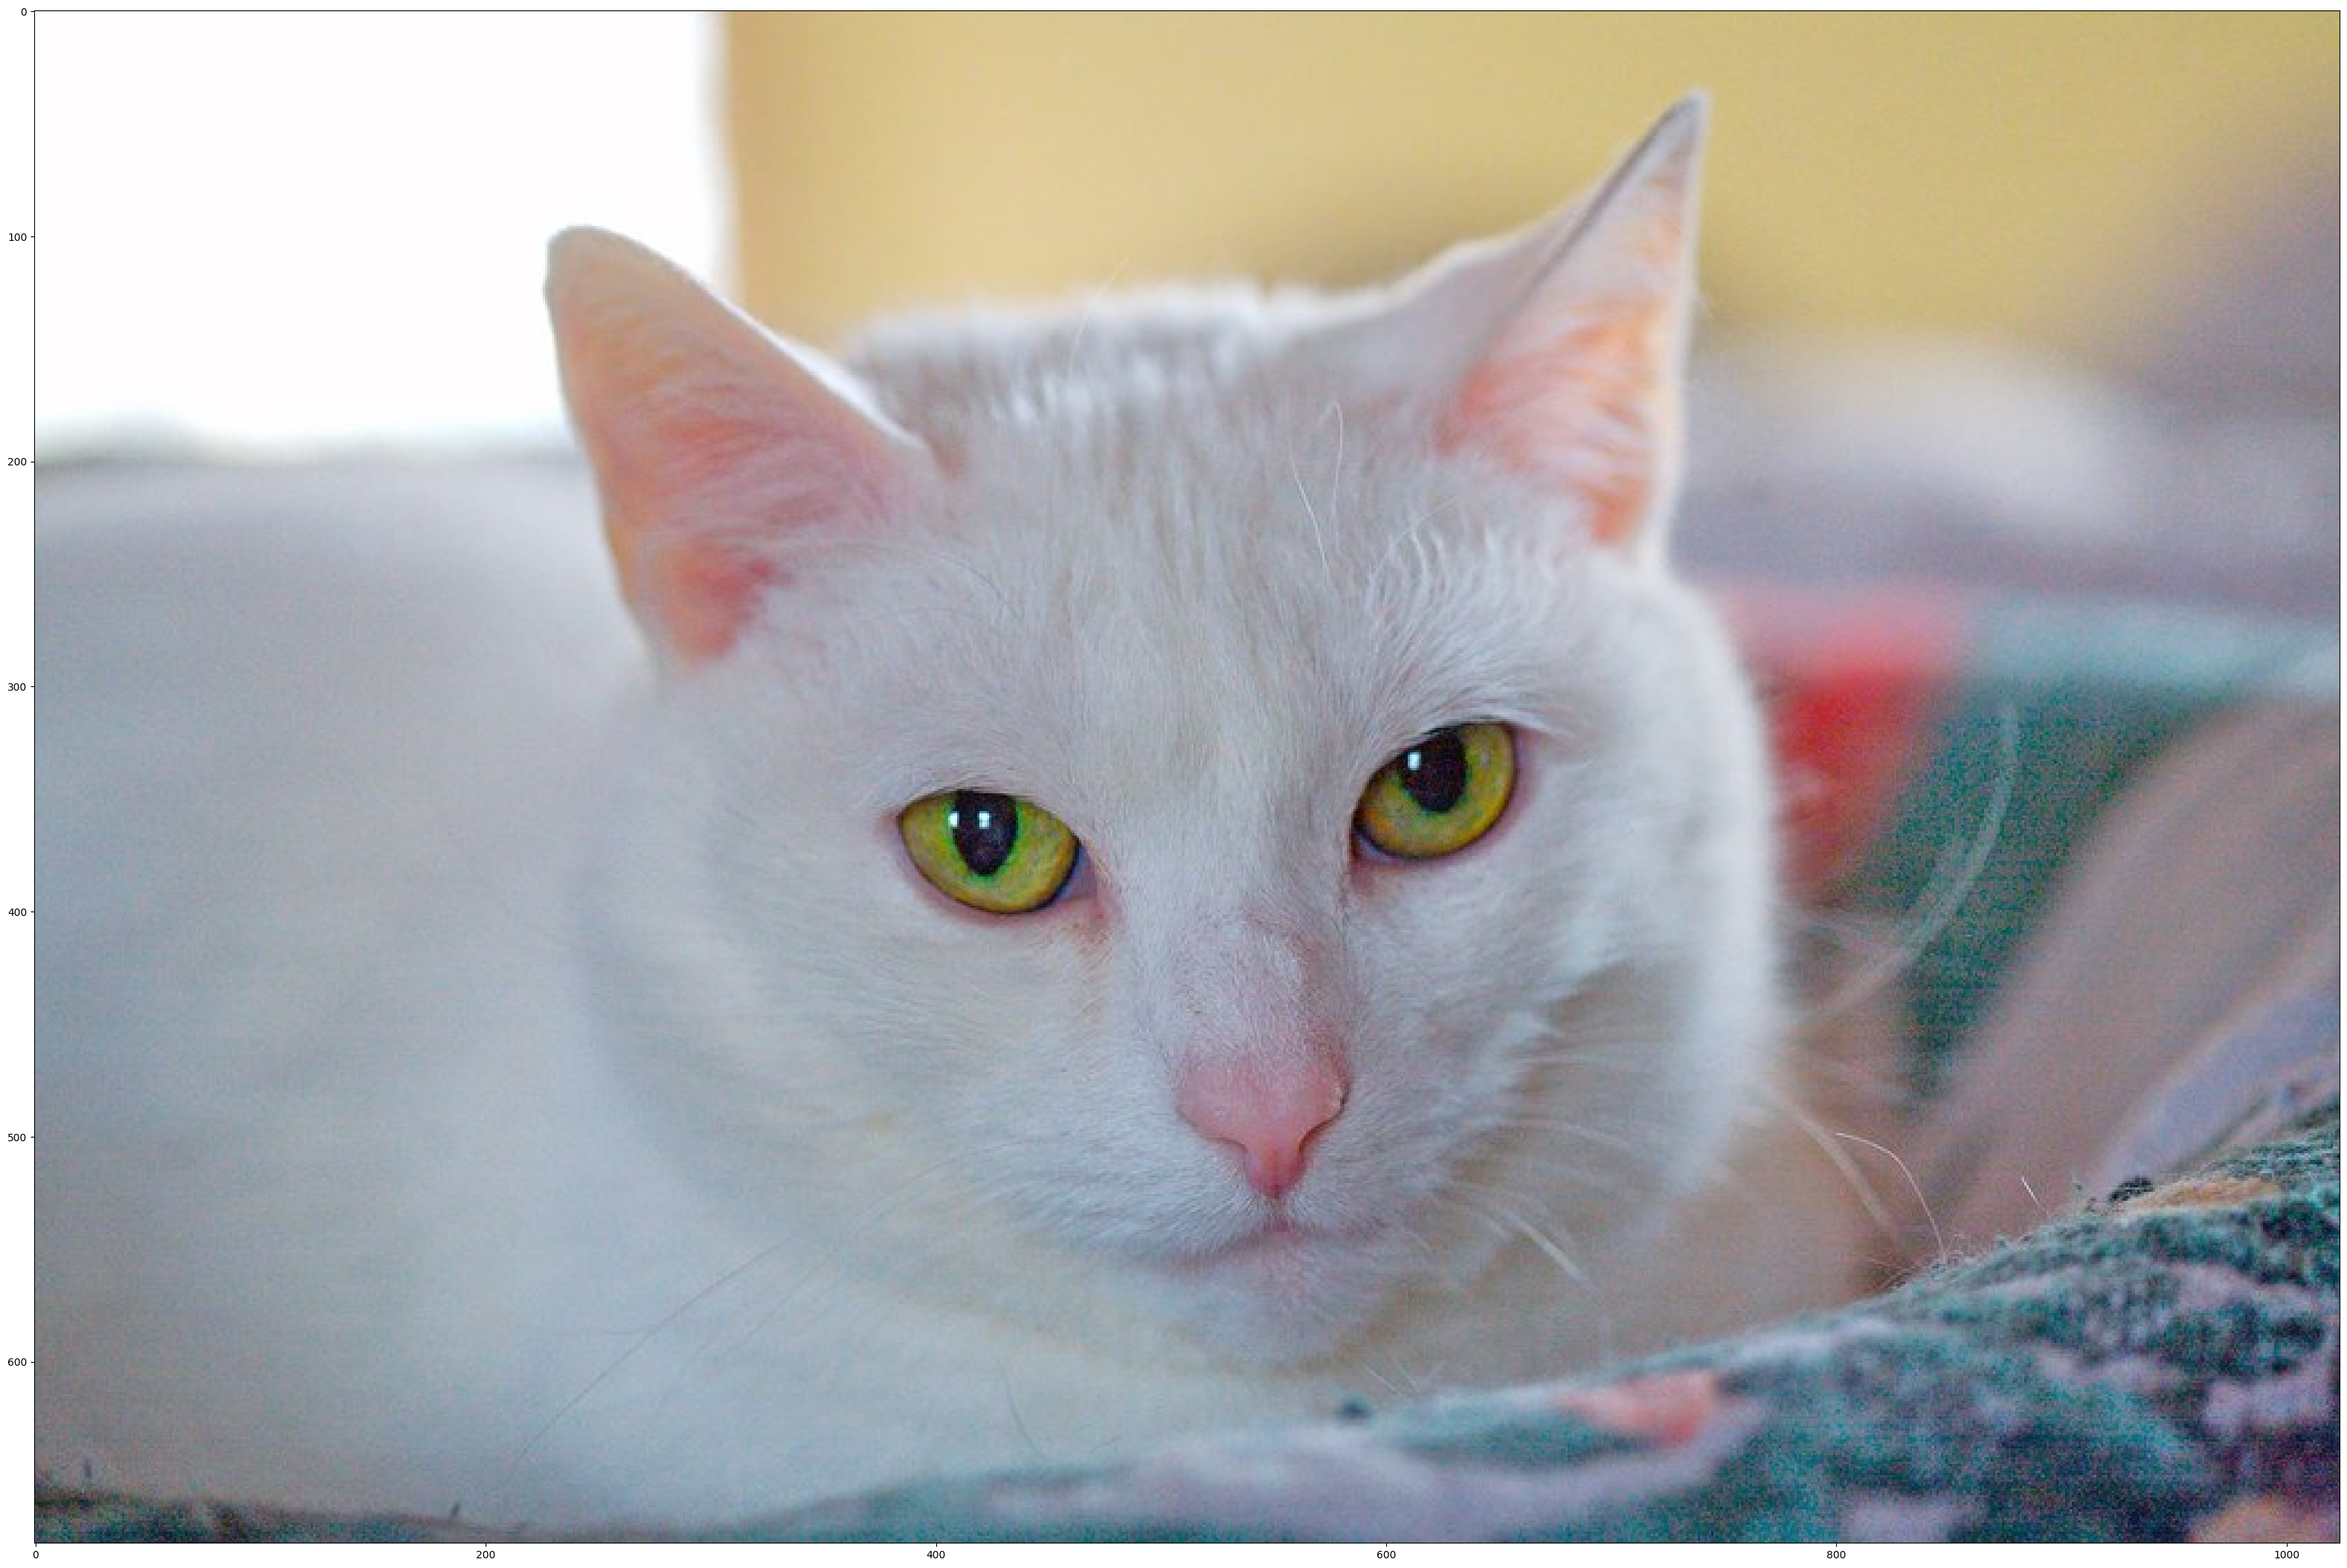

In [13]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = Image.open(fname)
my_image = np.array(image.resize((num_px, num_px))).reshape((1, num_px*num_px*3)).T
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<a id="part2"></a>
## Part 2: Full Machine Learning Project

Now you will use all you know about building and training neural networks in an "idea, code, experiment" cycle on a data set.

### 2.1 - Find a dataset (or datasets)

Find an appropriate dataset to work with. Some places to look:
- [Kaggle](https://www.kaggle.com/datasets) 
- [University of California, Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php)

You can choose just one, or more than one if you'd like to. Think carefully of the type of task you are trying to accomplish (e.g., classification, regression, etc.). Spend some time analyzing and processing the data. For example, decide how to split the data; should you have separate train, dev, and test sets? Does the data need to be cleaned or adjusted? How should the data be normalized? Any other considerations or adjustments needed for the data?

Clearly indicate where you found the dataset(s) you are working with.

Show the work you have done analyzing and processing the data in Python boxes in this notebook. There should also be associated markdown boxes discussing what you have observed and what decisions you have made.




In [32]:

# Your work for analyzing and processing the data
filename = "SPECTF.train"
# had the remove the first line of the csv file since it was a description of all the features of the data set
# Load the dataset
dataset = np.genfromtxt(filename, delimiter=",")

# Process the dataset
# y = dataset[:, -1]   # last column is the labels
# X = dataset[:, :-1]  # rest of columns are the inputs

# this is for the SPECTF data sets
X = dataset[: , 1:]
y = dataset[: , :1]

# processing for the breast cancer data set 
# y -= 2
# y /= 2

# X, y = X.T, y.reshape(1, y.shape[0])
# print(X.shape)
# print(y.shape)
print(X)

#print(y)




[[59. 52. 70. ... 74. 64. 67.]
 [72. 62. 69. ... 71. 56. 58.]
 [71. 62. 70. ... 41. 51. 46.]
 ...
 [67. 64. 73. ... 80. 67. 68.]
 [68. 65. 72. ... 56. 58. 44.]
 [66. 54. 69. ... 68. 59. 59.]]


Discussion:

We obtained this data set from the UCI Irvine Machine Learning Repository. This data set is concerned with determining whether bank notes are genuine or fraudulent. Not much processing was needed for this data set. We only had to seperate the inputs from the ground truth values using python's slicing operator. The truth values are stored in a vector labeled Y, while the inputs are stored in a vector labeled X. 

### 2.2 - Build your model

Start with a basic model, show the results, and then apply whichever improvements you decide to incorporate as per below.

You have two options for building your model:
- **The difficult option**: Use the provided L-layer network code used above in Part 1 and (later) extend it to incorporate more advanced neural network improvements as given in class
- **The easier option**: Use [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org) to build a network
	- You may *not* use any framework other than Keras/TensorFlow

Ambition will be rewarded! If you choose the easier option, you are expected to incorporate more of the potential improvements given below.

Some of the neural network improvements you can consider incorporating for either option (not an exhaustive list):
- Weight initialization methods (e.g., zeroes, random, etc.)
- Regularization: L2, dropout, etc.
- Mini-batch gradient descent
- Gradient descent optimization algorithm: momentum, RMSProp, Adam, etc.
- Batch normalization

Show the results with your model with improvements. Use markdown boxes to discuss the effect of your improvement(s) and change in accuracy.

In [39]:
# Your work for building a basic model and then applying improvements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

# # Define the keras model
# #layer 1
# model = Sequential()
# model.add(Dense(16,input_shape=(4,), activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# #layer 2
# model.add(Dense(8,activation = 'tanh'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# #layer 3
# model.add(Dense(1,activation = 'sigmoid'))
# model.add(BatchNormalization())

# #Compile the model 

# model.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'sgd',metrics = ['binary_accuracy'] )

# # Fit the model on the dataset
# model.fit(X,Y,epochs = 150, batch_size = 10, verbose = 0)

model = Sequential()
model.add(Dense(24, input_shape = (44,), activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(12, activation = 'tanh'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'sgd', metrics = ['binary_accuracy'])
model.fit(X,y,epochs = 250, batch_size = 10, verbose = 0)

#evaluate the model 
_, accuracy = model.evaluate(X,y)
print('Accuracy: %.2f' % (accuracy*100))

3/3 [==============================] - 0s 1ms/step - loss: 0.6894 - binary_accuracy: 0.5125
Accuracy: 51.25


Discussion: 



### 2.3 - Idea, Code, Experiment Cycle

Now go through a iterative process to improve your model. This will involve things like (not an exhaustive list):
- Checking whether you have a bias and/or variance problem. How will you address it? 
- Hyperparameter tuning: learning rate, # of layers, # of hidden units, activation functions, mini-batch size, etc.
- Trying any of the improvements made to the model in part 2.2 to see if it leads to better results

We want to see the progression of your model to a final version with the best results you can achieve. You don't have to show results for every single experiment you tried, but a general progression of different models at various stages of development should be included. Feel free to include discussion, diagrams, tables, and/or graphs that may summarize some of your experiments. **If you only show us the final model you've built, your mark will be minimal**.

Your discussion should also include details on the methodology you used in your experiments. For example, how did you approach hyperparameter tuning?


In [ ]:
# Your work for experiments


**Grading**: 
- Part 1 code for L_layer_model(): **10 marks**
- Part 2:
  - Dataset choice and analysis: **10 marks**
  - Building your model:
    - Basic model: **5 marks**
    - Implementing improvements to model: **15 marks**
  - Idea, Code, Experiment Cycle: **20 marks**

**Total** for project: **60 marks**

**Submission**: Submit a zip file containing all of the files/folders for your project. Make sure all files are included; do not assume we have certain files already.